## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer

## Load source datasets

In [2]:
train_df = pd.read_csv("../input/tabular-playground-series-may-2021/train.csv")
test_df = pd.read_csv("../input/tabular-playground-series-may-2021/test.csv")
print("train_df: {} \ntest_df: {}".format(train_df.shape, test_df.shape))

train_df: (100000, 52) 
test_df: (50000, 51)


In [3]:
train_df.set_index('id', inplace=True)
test_df.set_index('id', inplace=True)
train_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,1,0,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,0,0,0,0,0,0,0,0,0,2,...,0,1,0,0,0,0,13,2,0,Class_1
3,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2


## Data Cleansing

In [4]:
test_df.loc[test_df['feature_3']==25,'feature_3']=26
test_df.loc[test_df['feature_4']==36,'feature_4']=37
test_df.loc[test_df['feature_21']==31,'feature_21']=36
test_df.loc[test_df['feature_25']==24,'feature_25']=23
test_df.loc[test_df['feature_34']==26,'feature_34']=25
test_df.loc[test_df['feature_49']==21,'feature_49']=20

test_df.shape

(50000, 50)

In [5]:
train_df = train_df[train_df['feature_5']!=10]

train_df = train_df[train_df['feature_6']!=26]
train_df = train_df[train_df['feature_6']!=27]

train_df = train_df[train_df['feature_7']!=30]
train_df = train_df[train_df['feature_7']!=31]

train_df = train_df[train_df['feature_9']!=17]

train_df = train_df[train_df['feature_10']!=16]

train_df = train_df[train_df['feature_11']!=12]

train_df = train_df[train_df['feature_15']!=20]

train_df = train_df[train_df['feature_16']!=18]

train_df = train_df[train_df['feature_23']!=18]
train_df = train_df[train_df['feature_23']!=19]

train_df = train_df[train_df['feature_27']!=29]

train_df = train_df[train_df['feature_28']!=23]

train_df = train_df[train_df['feature_29']!=13]

train_df = train_df[train_df['feature_33']!=24]

train_df = train_df[train_df['feature_32']!=26]
train_df = train_df[train_df['feature_32']!=27]

train_df = train_df[train_df['feature_35']!=43]
train_df = train_df[train_df['feature_35']!=-2]
train_df = train_df[train_df['feature_35']!=38]
train_df = train_df[train_df['feature_35']!=39]


train_df = train_df[train_df['feature_38']!=65]
train_df = train_df[train_df['feature_38']!=55]
train_df = train_df[train_df['feature_38']!=-8]
train_df = train_df[train_df['feature_38']!=-3]
train_df = train_df[train_df['feature_38']!=-2]
train_df = train_df[train_df['feature_38']!=63]

train_df = train_df[train_df['feature_39']!=65]
train_df = train_df[train_df['feature_39']!=66]
train_df = train_df[train_df['feature_39']!=-5]
train_df = train_df[train_df['feature_39']!=-3]
train_df = train_df[train_df['feature_39']!=-2]
train_df = train_df[train_df['feature_39']!=63]

train_df = train_df[train_df['feature_42']!=37]
train_df = train_df[train_df['feature_42']!=-2]
train_df = train_df[train_df['feature_42']!=-1]

train_df = train_df[train_df['feature_43']!=33]
train_df = train_df[train_df['feature_43']!=31]

train_df.shape

(99918, 51)

## Extract target labels

In [6]:
class_map = {
    'Class_1': 0,
    'Class_2': 1,
    'Class_3': 2,
    'Class_4': 3
}

train_df['target'] = train_df['target'].map(class_map)
train_df.groupby(['target']).size().reset_index().rename(columns={0:'Count'})

,target,Count
0,0,8481
1,1,57446
2,2,21408
3,3,12583


In [7]:
train_y = train_df['target'].values
train_df.drop(['target'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))

train_y: (99918,)


## Feature Engineering

In [8]:
combined_df = train_df.append(test_df, sort=False, ignore_index=False)
combined_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,1,0,0,0,0,0,...,3,0,0,21,0,0,0,0,0,0
1,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,13,2,0
3,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
for col in tqdm(train_df.columns):
    combined_df[col+'_sq'] = combined_df[col].apply(lambda x: x**2)
    combined_df[col+'_cb'] = combined_df[col].apply(lambda x: x**3)
    combined_df[col+'_cbrt'] = combined_df[col].apply(lambda x: np.cbrt(x))

combined_df.head()

100%|██████████| 50/50 [00:29<00:00,  1.67it/s]


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_46_cbrt,feature_47_sq,feature_47_cb,feature_47_cbrt,feature_48_sq,feature_48_cb,feature_48_cbrt,feature_49_sq,feature_49_cb,feature_49_cbrt
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,1,0,0,0,0,0,...,0.0,0,0,0.000000,0,0,0.000000,0,0,0.0
1,0,0,0,0,2,1,0,0,0,0,...,0.0,0,0,0.000000,0,0,0.000000,0,0,0.0
2,0,0,0,0,0,0,0,0,0,2,...,0.0,169,2197,2.351335,4,8,1.259921,0,0,0.0
3,0,0,0,0,0,0,0,3,0,0,...,0.0,0,0,0.000000,1,1,1.000000,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.000000,1,1,1.000000,0,0,0.0


In [10]:
col_fltr_list = ['feature_14','feature_19','feature_30','feature_31','feature_32',
                 'feature_35','feature_38','feature_39','feature_42']
col_list = [col for col in train_df.columns if col not in col_fltr_list]

for col in tqdm(col_list):
    combined_df[col+'_log'] = combined_df[col].apply(lambda x: np.log1p(x))
    combined_df[col+'_sqrt'] = combined_df[col].apply(lambda x: np.sqrt(x))

combined_df.head()

100%|██████████| 41/41 [00:29<00:00,  1.37it/s]


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_45_log,feature_45_sqrt,feature_46_log,feature_46_sqrt,feature_47_log,feature_47_sqrt,feature_48_log,feature_48_sqrt,feature_49_log,feature_49_sqrt
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0,0,0,0,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0,0,0,0,0,0,0,0,0,2,...,0.0,0.0,0.0,0.0,2.639057,3.605551,1.098612,1.414214,0.0,0.0
3,0,0,0,0,0,0,0,3,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.693147,1.000000,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.693147,1.000000,0.0,0.0


In [11]:
combined_df[combined_df.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_45_log,feature_45_sqrt,feature_46_log,feature_46_sqrt,feature_47_log,feature_47_sqrt,feature_48_log,feature_48_sqrt,feature_49_log,feature_49_sqrt
id,,,,,,,,,,,,,,,,,,,,,


In [12]:
col_filter_list = []

for col in combined_df.columns:
    uniq_val = combined_df[col].nunique()
    if uniq_val <= 2:
        col_filter_list.append(col)

combined_df.drop(col_filter_list, axis=1, inplace=True)
combined_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_45_log,feature_45_sqrt,feature_46_log,feature_46_sqrt,feature_47_log,feature_47_sqrt,feature_48_log,feature_48_sqrt,feature_49_log,feature_49_sqrt
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0,0,0,0,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0,0,0,0,0,0,0,0,0,2,...,0.0,0.0,0.0,0.0,2.639057,3.605551,1.098612,1.414214,0.0,0.0
3,0,0,0,0,0,0,0,3,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.693147,1.000000,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.693147,1.000000,0.0,0.0


In [13]:
train_df = combined_df[:train_y.shape[0]].copy()
test_df = combined_df[train_y.shape[0]:].copy()

del combined_df
gc.collect()

train_df.shape, test_df.shape

((99918, 282), (50000, 282))

## Quantile Transformation

In [14]:
for col in tqdm(train_df.columns):
    transformer = QuantileTransformer(n_quantiles=1000, 
                                      random_state=10, 
                                      output_distribution="normal")
    
    vec_len = len(train_df[col].values)
    vec_len_test = len(test_df[col].values)

    raw_vec = train_df[col].values.reshape(vec_len, 1)
    test_vec = test_df[col].values.reshape(vec_len_test, 1)
    transformer.fit(raw_vec)
    
    train_df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_df[col] = transformer.transform(test_vec).reshape(1, vec_len_test)[0]

100%|██████████| 282/282 [00:12<00:00, 22.79it/s]


## PCA features

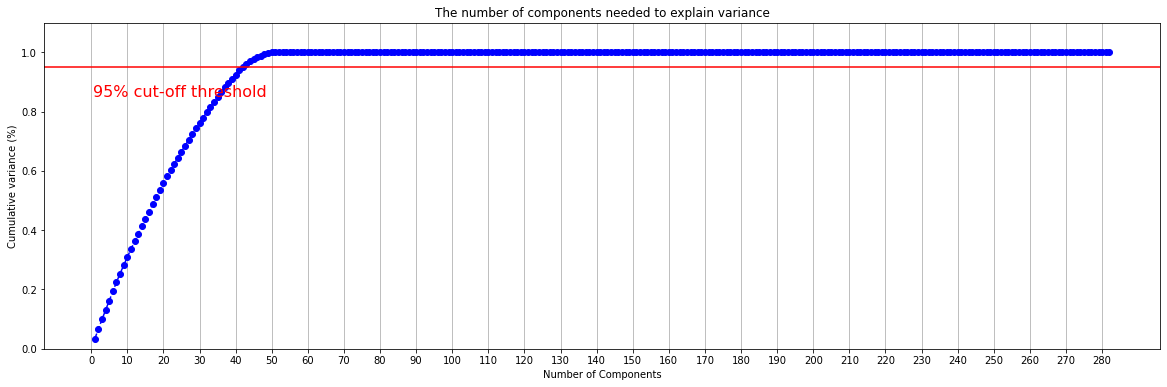

In [15]:
# Deciding n_components for PCA
data = pd.concat([train_df, test_df], axis=0)
pca = PCA().fit(data)
plt.rcParams["figure.figsize"] = (20,6)

fig, ax = plt.subplots()
xi = np.arange(1, 283, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 282, step=10))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [16]:
def pca_fet(train, test, features, n_components, SEED=10):
    train_ = train[features].copy()
    test_ = test[features].copy()
    data = pd.concat([train_, test_], axis=0)
    index = data.index

    pca = PCA(n_components=n_components, random_state=SEED)
    data = pca.fit_transform(data)
    columns = [f'pca_{i + 1}' for i in range(n_components)]
    data = pd.DataFrame(data, columns=columns, index=index)
    
    train_ = data.iloc[:train.shape[0]]
    test_ = data.iloc[train.shape[0]:]
    train = pd.concat([train, train_], axis=1)
    test = pd.concat([test, test_], axis=1)
    return train, test

In [17]:
train_df, test_df = pca_fet(train_df, test_df, train_df.columns, n_components=40)
print("train_df: {} \ntest_df: {}".format(train_df.shape, test_df.shape))

train_df: (99918, 322) 
test_df: (50000, 322)


In [18]:
train_df['target'] = train_y.ravel()
train_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,target
id,,,,,,,,,,,,,,,,,,,,,
0,-5.199338,-5.199338,1.684464,-5.199338,1.340200,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,3.659480,5.222827,12.341668,-0.909891,-1.925744,-2.584480,-1.670998,1.022932,-0.898381,1
1,-5.199338,-5.199338,-5.199338,-5.199338,1.602210,1.490335,-5.199338,-5.199338,-5.199338,-5.199338,...,5.632319,7.129015,12.919916,-1.622329,-1.599182,12.567133,-7.503364,-2.301243,-1.827977,0
2,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.953493,...,10.682282,-4.566511,-4.901887,-6.106147,-4.166421,2.892257,17.145796,0.216164,-1.984056,0
3,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.093272,-5.199338,-5.199338,...,-1.542569,-1.453520,0.805692,-2.012552,-1.357286,-1.191840,-0.882681,0.701943,-2.094933,3
4,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,-1.937296,-1.553096,0.565112,-1.552542,-0.994492,-1.962425,-1.105414,0.502602,-1.481902,1


## Save the processed datasets

In [19]:
data_dict = {}
data_dict['train_df'] = train_df
data_dict['test_df'] = test_df

file = open("./TPS_May_Dataset.txt", 'wb')
pickle.dump(data_dict, file)
file.close()